In [1]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from anstey.generate import T_CMB
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

In [2]:
saveloc = "Nregs_pl_gsmalo/"


def load_chain(savename, burn_in=5000, thin=1, end=-1, suffix='_1'):
    """
    Load the chain, burning in, thinning and flattening.
    """
    chain = np.load(f"saves/{saveloc}"+savename+suffix+".npy")
    print("Loaded chain of orginal shape", chain.shape)
    chain = chain[burn_in:end:thin]
    ch_sh = np.shape(chain)
    chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
    return chain_flat


def param_estimator(chain, stats="mean"):
    if stats=="mean":
        theta_est = np.mean(chain, axis=0)
    elif stats=="max":
        c = ChainConsumer()
        c.add_chain(chain, statistics=stats)
        analysis_dict = c.analysis.get_summary(squeeze=True)
        theta_est = np.array([val[1] for val in analysis_dict.values()])
    return theta_est


def plot_chain(*chains, stats=None, walks=False):
    """
    Plot the corner figure of the foreground inference.
    """
    c=ChainConsumer()
    params = [r'$\gamma_{n}$'.replace('n', str(n)) for n in range(1, Nreg+1)]
    
    for chain in chains:
        c.add_chain(chain, parameters=params)
        print("Plotting chain of shape", chain.shape)
    if walks:
        c.plotter.plot_walks()
    elif not walks:
        c.plotter.plot()
    plt.show()


def showcase_model_residuals(chain, Nreg, savename, stats="mean"):
    # Generate most-likely data.
    theta_est = param_estimator(chain, stats)

    # Load the observation parameters and instantiate the inferred model.
    with open(f"saves/{saveloc}{savename}_pars.pkl", 'rb') as f:
        pars = load(f)
    model = NRI.main(return_model=True, Nregions=Nreg, times=pars["times"], lmax=pars["lmax"], nside=pars["nside"], Ntau=pars["Ntau"])#Ntau=1)
    if "unoise" in savename:
        noise = pars['unoise']
    elif "radnoise" in savename:
        raise NotImplementedError
    model_temps = model(theta=theta_est)
    
    data = np.load(f"saves/{saveloc}{savename}_data.npy")
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(data, '.', label='data')
    ax[0].plot(model_temps, '.', label='model')
    ax[1].errorbar(range(len(data)), data-model_temps, yerr=noise, fmt='.')
    ax[0].set_xlabel('bin')
    ax[1].set_xlabel('bin')
    ax[0].set_ylabel('Temperature [K]')
    ax[1].set_ylabel('Temperature residuals [K]')
    ax[0].legend()
    fig.tight_layout()
    fig.show()


def visualise_fgs(chain, Nreg, stats="mean", nside=16):
    theta_est = param_estimator(chain, stats=stats)
    indx = np.load(f"anstey/indexes_{nside}.npy")
    
    mask_maps, _ = NRI.mask_split(Nregions=Nreg, nside=nside)
    fidmap = SM.foreground_gsma_nsidelo(60, nside=nside)
    
    hp.mollview(np.split(pix_forward_model_pl(powers=theta_est, nuarr=nuarr, base_map=indx[0], masks=mask_maps), 51)[10], title='model estimate')
    plt.show()
    
    hp.mollview(fidmap, title='fiducial sky')
    plt.show()
    hp.mollview(np.abs(fidmap-np.split(pix_forward_model_pl(powers=theta_est, nuarr=nuarr, base_map=indx[0], masks=mask_maps), 51)[10]), title='|fiducial-model|')
    plt.show()
    sns.histplot(fidmap-np.split(pix_forward_model_pl(powers=theta_est, nuarr=nuarr, base_map=indx[0], masks=mask_maps), 51)[10], bins=50)
    plt.show()

In [6]:
NRI.main(6, 100000, uniform_noise=True, unoise_K=1., lmax=32, nside=8, tag="_debug06")

calc_spherical_harmonic_matrix npix, nalm : 768 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 768 561
 :: shape masks= 6
 :: shape masked_basemaps= 6
 :: shape mask_vecs= (6, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:34<00:00, 299.29it/s]


Loaded chain of orginal shape (100000, 32, 6)
Plotting chain of shape (3039968, 6)


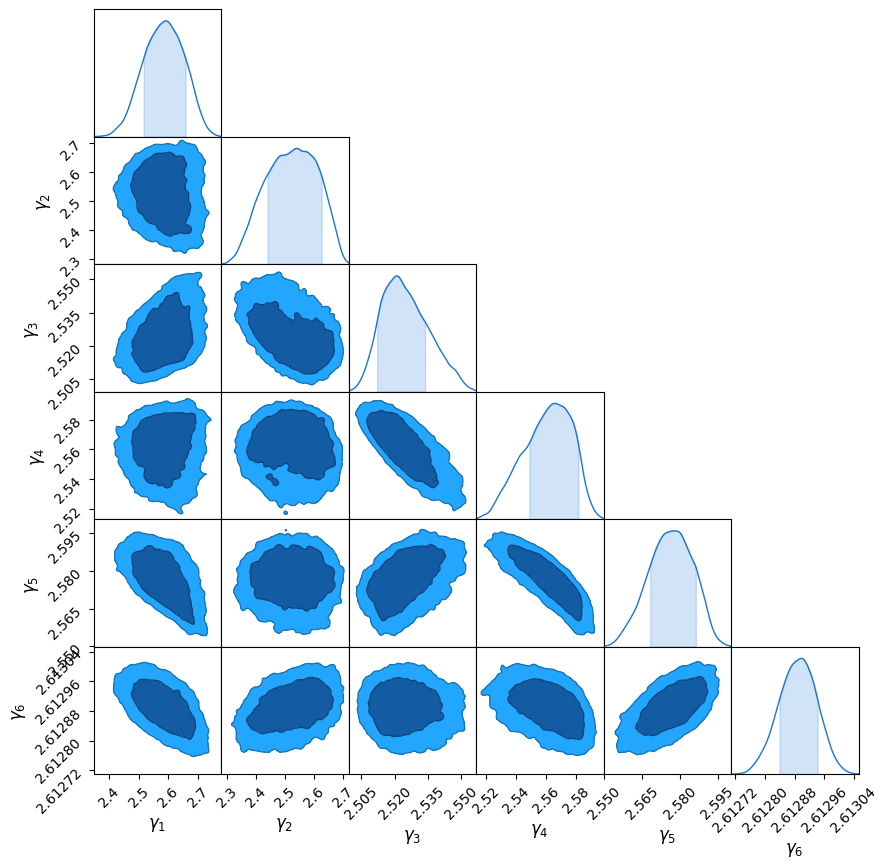

In [7]:
Nreg = 6
savename = f"{Nreg}reg_unoise_debug06"
chain = load_chain(savename, burn_in=10000, thin=1, end=-1, suffix="")
plot_chain(chain, walks=False)

calc_spherical_harmonic_matrix npix, nalm : 768 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 768 561
 :: shape masks= 6
 :: shape masked_basemaps= 6
 :: shape mask_vecs= (6, 3)


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_10776/4248203710.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


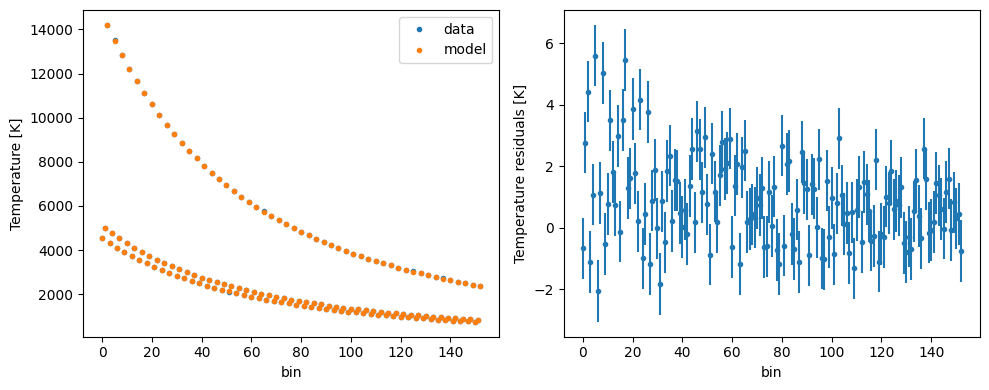

In [8]:
showcase_model_residuals(chain, Nreg, savename, stats="mean")

In [9]:
NRI.main_threerun(9, uniform_noise=True, times=np.linspace(0,6,3), tag='_nside08_noise500mK', nside=8, unoise_K=.5, Ntau=3, steps=250000)

calc_spherical_harmonic_matrix npix, nalm : 768 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 768 561
 :: shape masks= 9
 :: shape masked_basemaps= 9
 :: shape mask_vecs= (9, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250000/250000 [09:31<00:00, 437.62it/s]


Loaded chain of orginal shape (250000, 32, 9)
Plotting chain of shape (76800, 9)


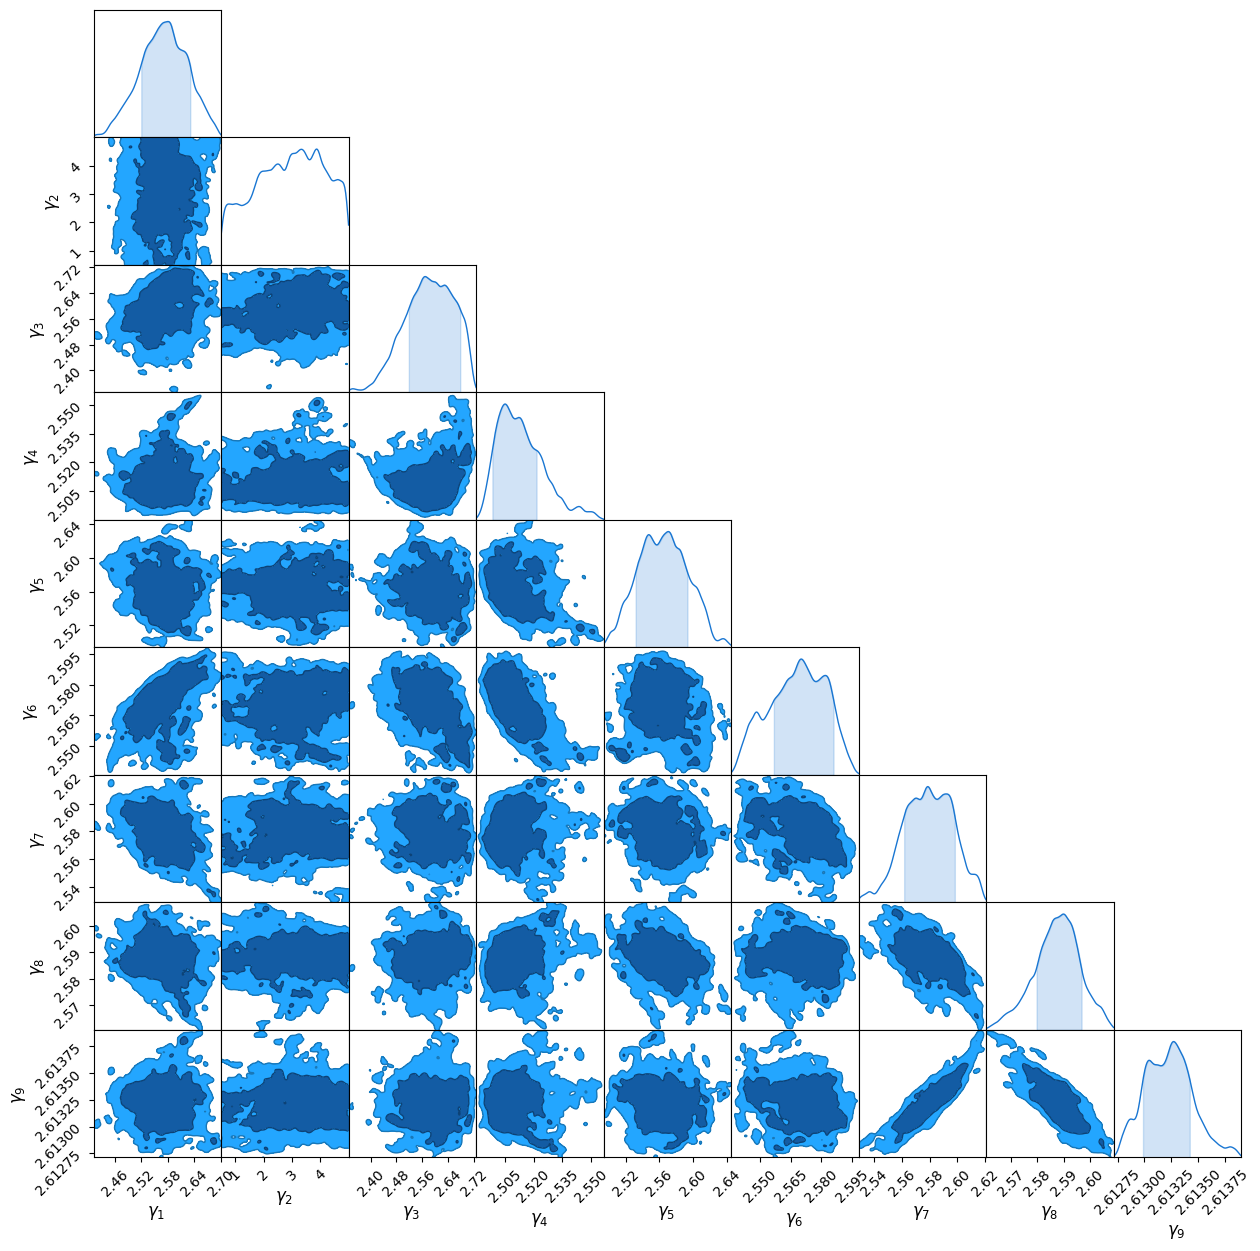

In [12]:
Nreg = 9
savename = f"{Nreg}reg_unoise_nside08_noise500mK"
chain = load_chain(savename, burn_in=10000, thin=100, end=-1, suffix="_2")
plot_chain(chain, walks=False)

calc_spherical_harmonic_matrix npix, nalm : 768 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 768 561
 :: shape masks= 9
 :: shape masked_basemaps= 9
 :: shape mask_vecs= (9, 3)


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_10776/4248203710.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


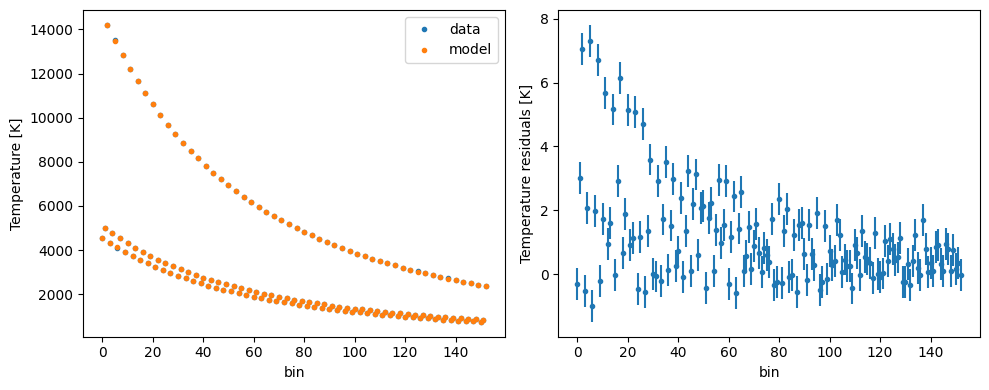

In [13]:
showcase_model_residuals(chain, Nreg, savename, stats="mean")

In [14]:
NRI.main_threerun(8, uniform_noise=True, times=np.linspace(0,6,3), tag='_nside08_noise500mK', nside=8, unoise_K=.5, Ntau=3, steps=250000)

calc_spherical_harmonic_matrix npix, nalm : 768 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 768 561
 :: shape masks= 8
 :: shape masked_basemaps= 8
 :: shape mask_vecs= (8, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250000/250000 [09:51<00:00, 422.73it/s]


Loaded chain of orginal shape (250000, 32, 8)
Plotting chain of shape (76800, 8)


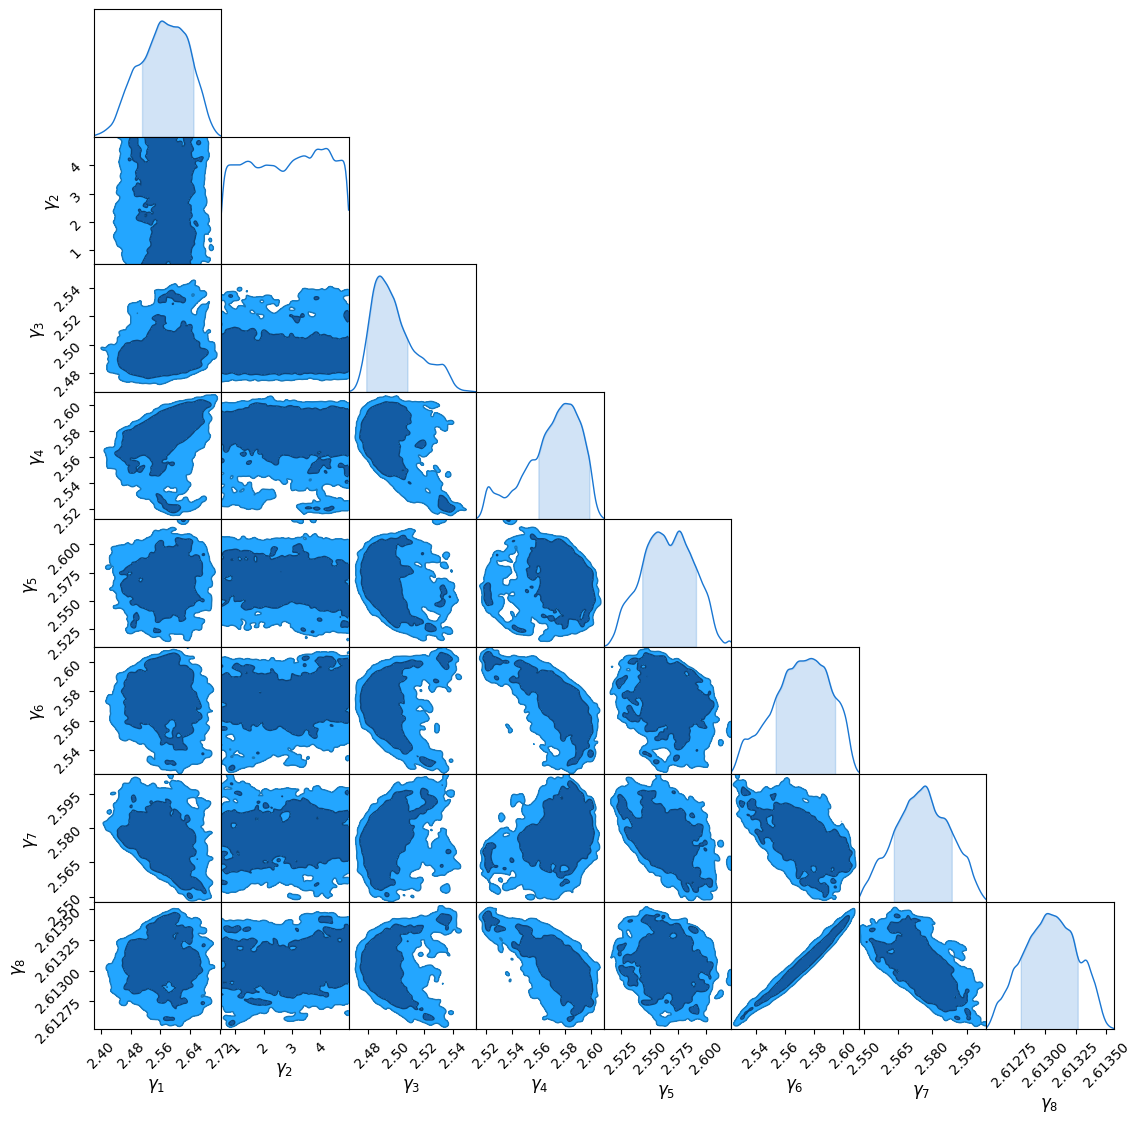

In [15]:
Nreg = 8
savename = f"{Nreg}reg_unoise_nside08_noise500mK"
chain = load_chain(savename, burn_in=10000, thin=100, end=-1, suffix="_2")
plot_chain(chain, walks=False)

calc_spherical_harmonic_matrix npix, nalm : 768 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 768 561
 :: shape masks= 8
 :: shape masked_basemaps= 8
 :: shape mask_vecs= (8, 3)


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_10776/4248203710.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


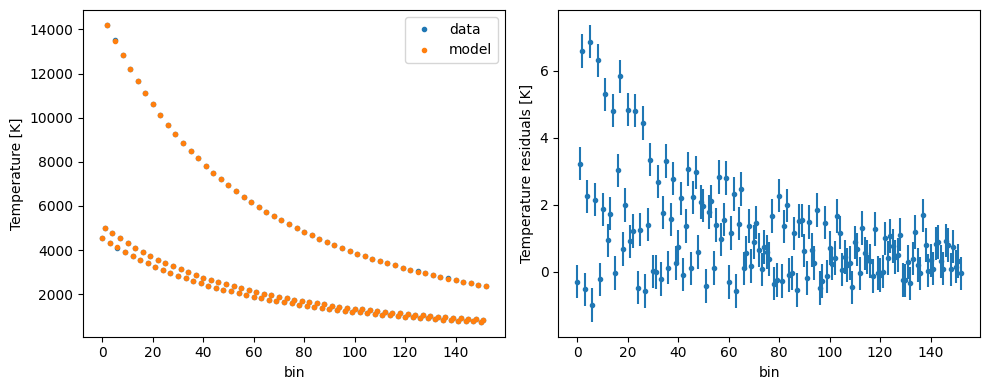

In [16]:
showcase_model_residuals(chain, Nreg, savename, stats="mean")

In [3]:
NRI.main_threerun(9, uniform_noise=True, times=np.linspace(0,6,3), tag='_noise500mK', nside=16, unoise_K=.5, Ntau=3, steps=500000)

calc_spherical_harmonic_matrix npix, nalm : 3072 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 3072 561
 :: shape masks= 9
 :: shape masked_basemaps= 9
 :: shape mask_vecs= (9, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [20:13<00:00, 412.08it/s]


Loaded chain of orginal shape (500000, 32, 9)
Plotting chain of shape (156800, 9)


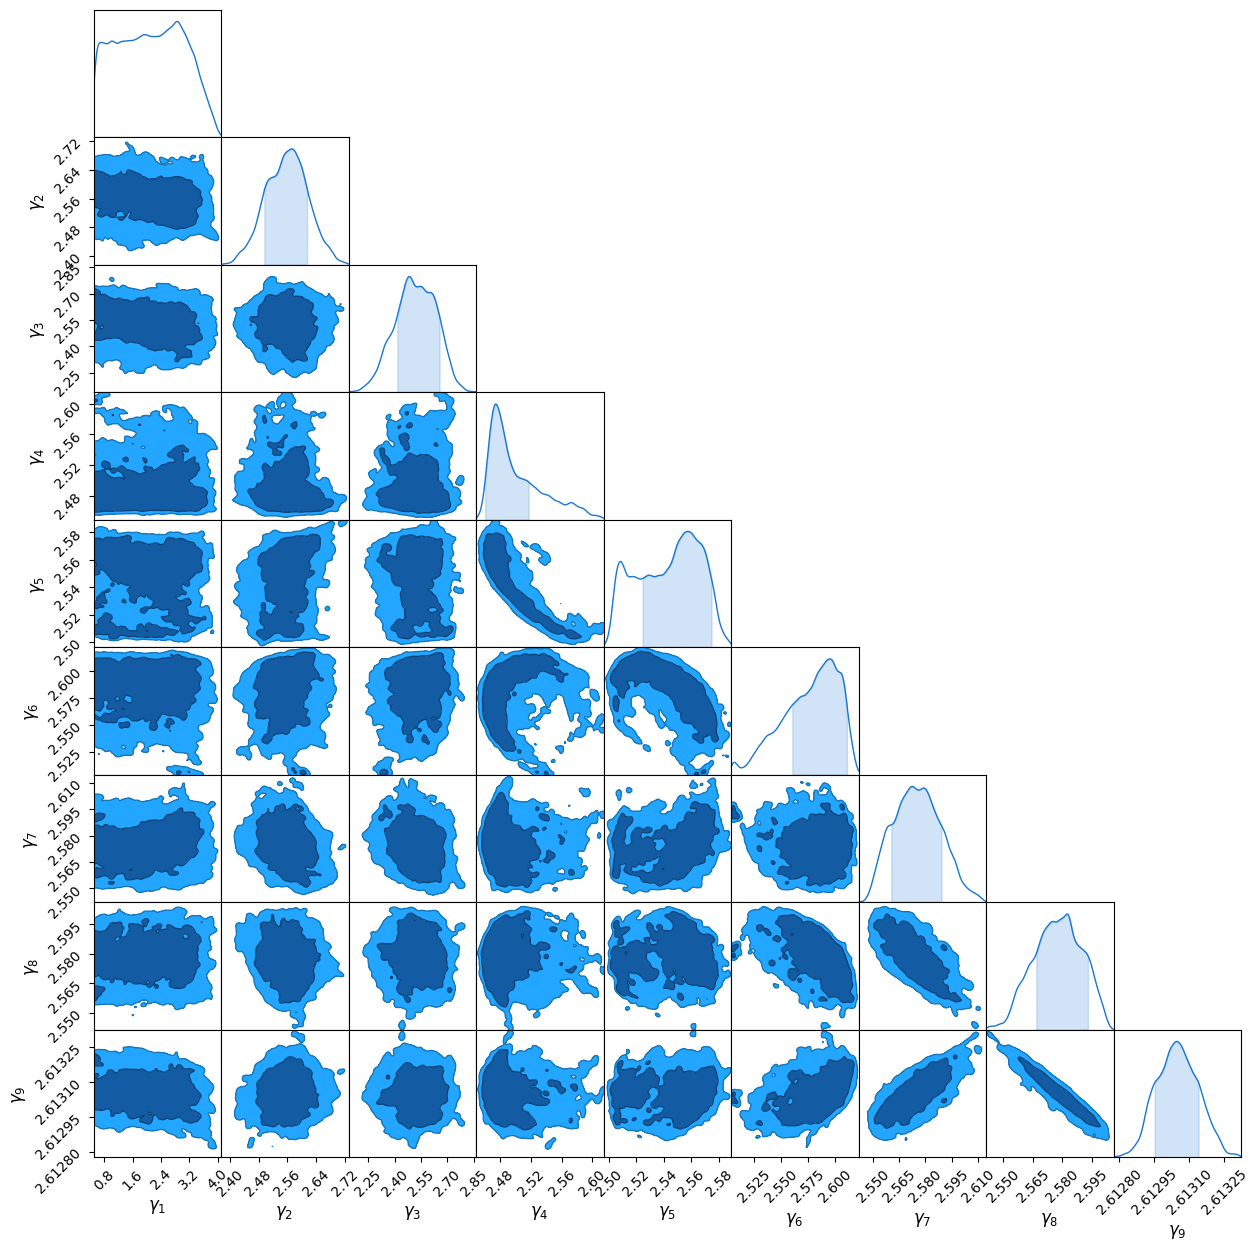

In [6]:
Nreg = 9
savename = f"{Nreg}reg_unoise_noise500mK"
chain = load_chain(savename, burn_in=10000, thin=100, end=-1, suffix="_2")
plot_chain(chain, walks=False)

calc_spherical_harmonic_matrix npix, nalm : 3072 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


calc_spherical_harmonic_matrix npix, nalm : 3072 561
 :: shape masks= 9
 :: shape masked_basemaps= 9
 :: shape mask_vecs= (9, 3)


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_16699/4248203710.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


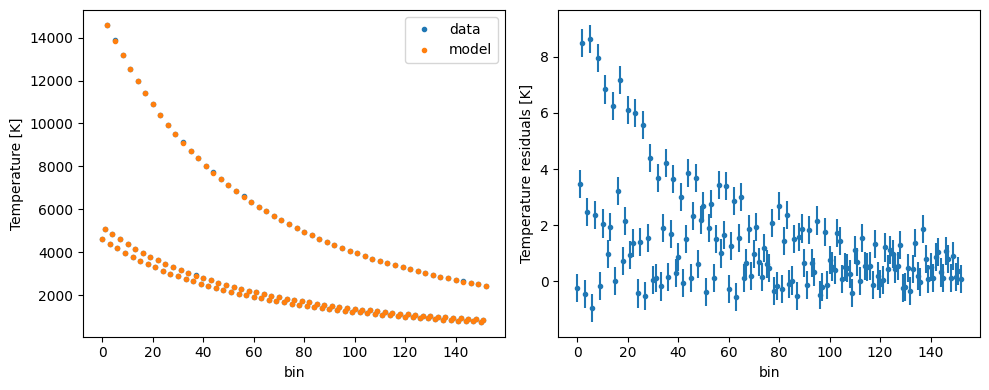

In [7]:
showcase_model_residuals(chain, Nreg, savename, stats="mean")

In [3]:
NRI.main_threerun(9, uniform_noise=True, times=np.linspace(0,6,3), tag='_nside32_noise500mK', nside=32, unoise_K=.5, Ntau=3, steps=500000, lmax=64, pre_steps=40000)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


 :: shape masks= 9
 :: shape masked_basemaps= 9
 :: shape mask_vecs= (9, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [22:06<00:00, 376.82it/s]


Loaded chain of orginal shape (500000, 32, 9)
Plotting chain of shape (128000, 9)


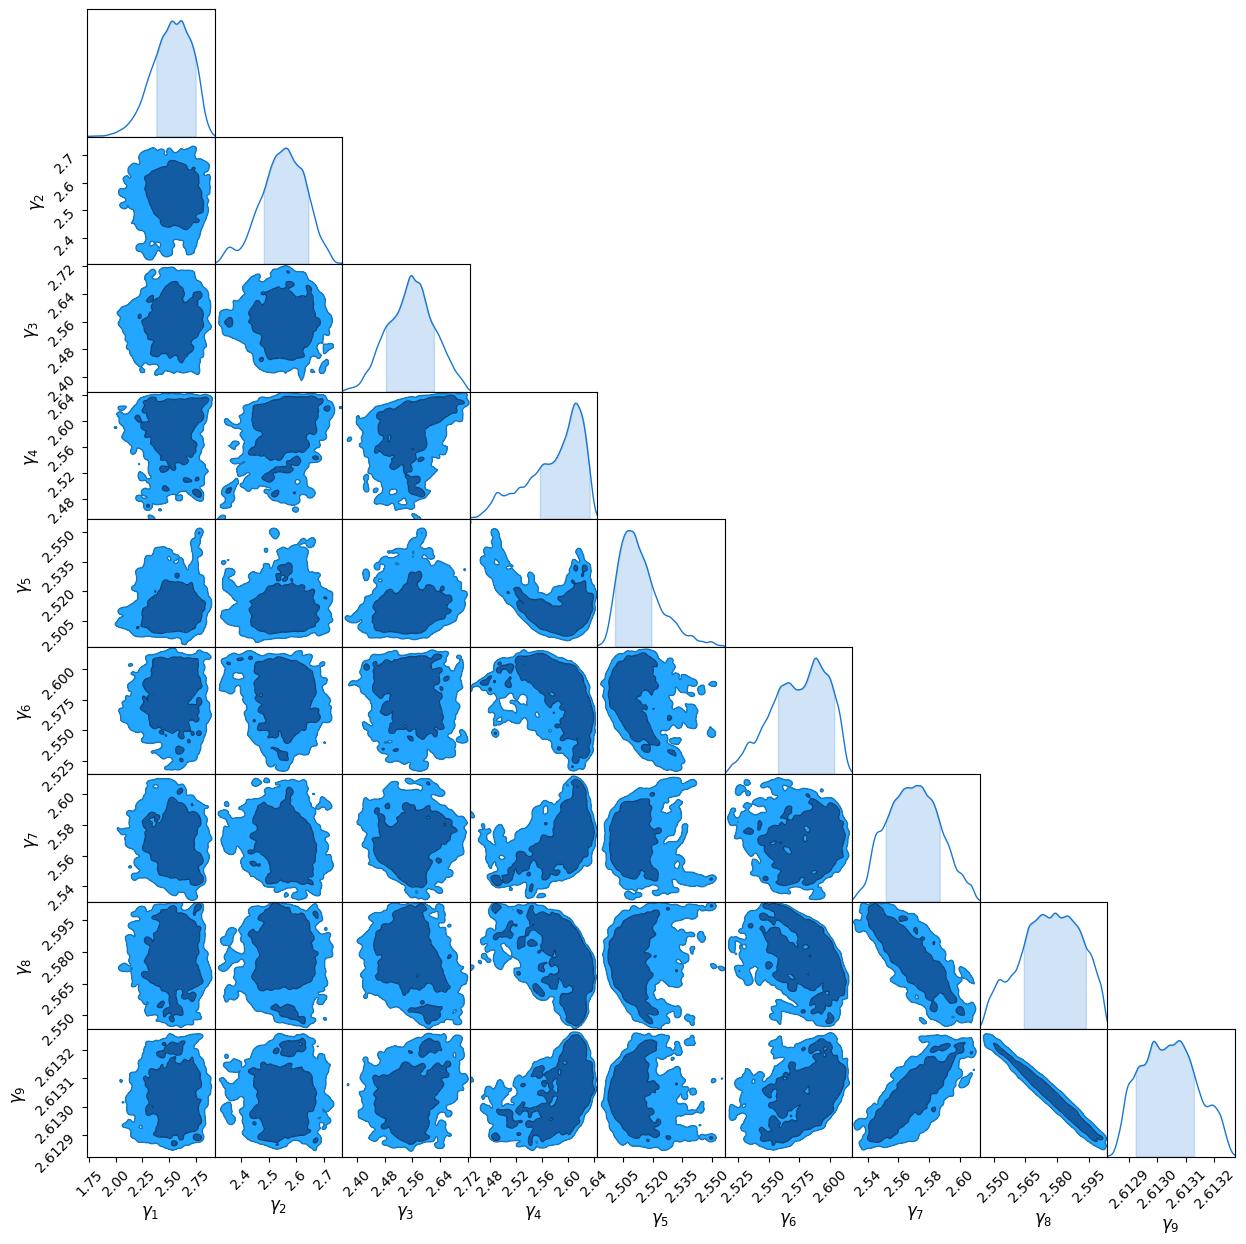

In [6]:
Nreg = 9
savename = f"{Nreg}reg_unoise_nside32_noise500mK"
chain = load_chain(savename, burn_in=100000, thin=100, end=-1, suffix="_2")
plot_chain(chain, walks=False)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


 :: shape masks= 9
 :: shape masked_basemaps= 9
 :: shape mask_vecs= (9, 3)


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_23336/4248203710.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


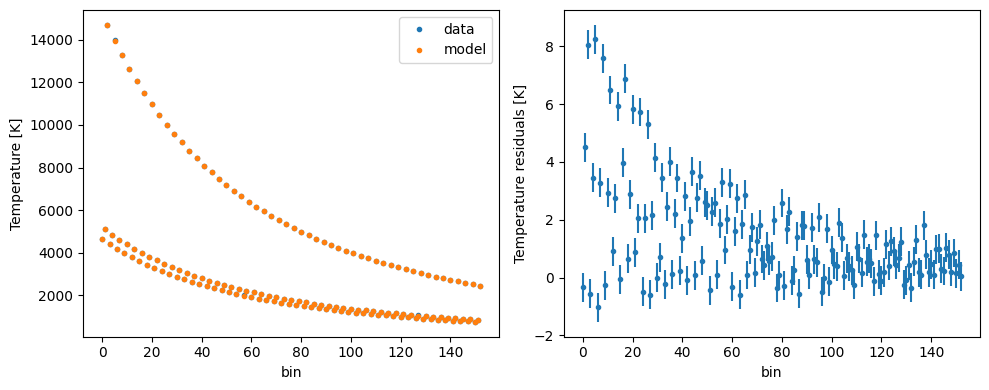

In [7]:
showcase_model_residuals(chain, Nreg, savename, stats="mean")